<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Age-Category-and-Gender-Prediction/blob/main/AGE_AND_GENDER_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T164657Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2096b4144d3edfcf99f7ea8837fafffd8669eff0debfcbd5d79192d44ab8d4b8503bb4b0d9a26351980edff0f467c68f4d582c18dfe51930e2c268aa2f7762ed6626bce9c841d792f46594b8275d9068e2c00171b1388e604843fae84e4bf36174181bbf5465ced4985952ac2ce6dcc22b533455be0b4f0ab7ec328abdc9254f00a5b730d9cfbd57f2c37b6f099b0586bf8684095291ecd75003d03655931cdf8326cf81facacb069500d3d3d076f3f0cfae0b3c89ae65090fe664ade5d63e80f9bec9a90844368051983ce6096f1f4e05eb55666cb8ac4da8fb2ab6467060b779b05665a40aa3f42f97c06c4a43ce9a3e97cf551de52f11735bfdd70fded5e1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [3]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os
import pandas as pd

from fastai.vision.all import *

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [4]:
image_id = os.listdir("/kaggle/input/utkface-new/UTKFace")
image_age = [i.split("_")[0] for i in image_id]
image_gender = [i.split("_")[1] for i in image_id]

df = pd.DataFrame({
                    "image_id":image_id,
                    "image_age":image_age,
                    "image_gender":image_gender
                })

df["image_gender"] = df["image_gender"].map({"0":"Male", "1":"Female"})

print(df.shape)

df.head()

(23708, 3)


,image_id,image_age,image_gender
0,75_0_3_20170105180253006.jpg.chip.jpg,75,Male
1,7_1_4_20170103212641884.jpg.chip.jpg,7,Female
2,63_0_3_20170119211951488.jpg.chip.jpg,63,Male
3,1_0_0_20170110213508380.jpg.chip.jpg,1,Male
4,86_1_0_20170120225525242.jpg.chip.jpg,86,Female


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      23708 non-null  object
 1   image_age     23708 non-null  object
 2   image_gender  23708 non-null  object
dtypes: object(3)
memory usage: 555.8+ KB


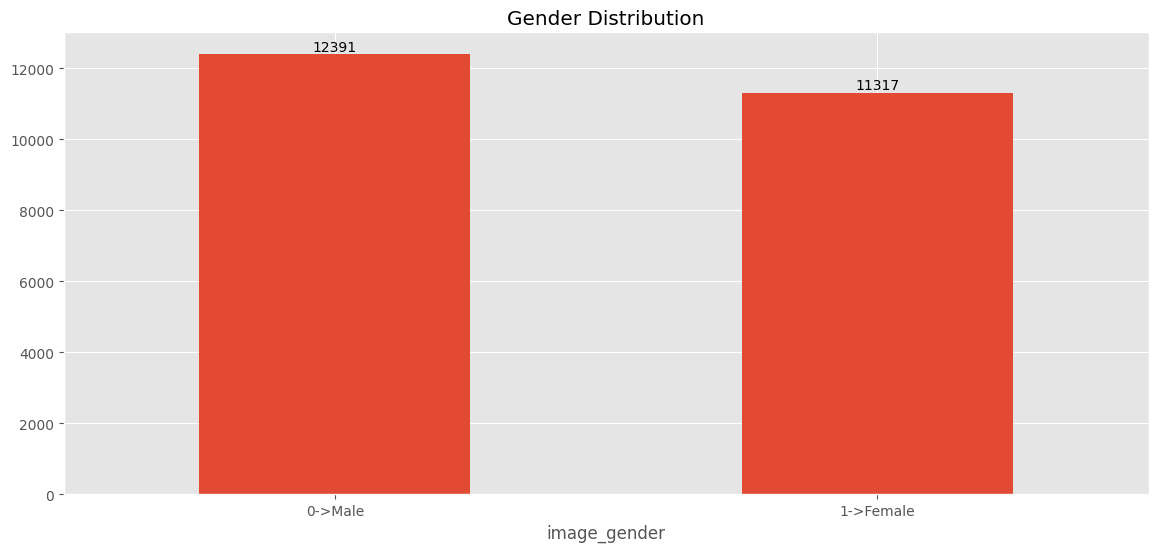

In [6]:
gender_dist = df["image_gender"].value_counts().plot(kind="bar", title="Gender Distribution", figsize=(14, 6))

for p in gender_dist.patches:
    h = p.get_height()
    gender_dist.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

gender_dist.set_xticklabels(labels=["0->Male", "1->Female"], rotation=0)

plt.show()

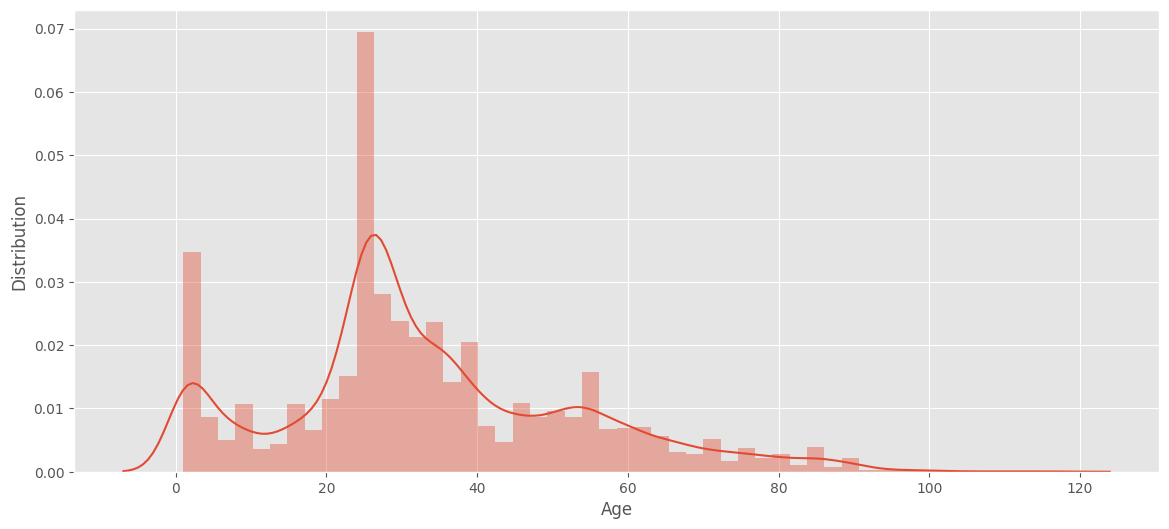

In [7]:
plt.figure(figsize=(14, 6))
sns.distplot(df["image_age"])
plt.xlabel("Age")
plt.ylabel("Distribution")
plt.show()

In [8]:
X_gender = df["image_id"]
y_gender = df["image_gender"]

In [9]:
xtrain_gender, xtest_gender, ytrain_gender, ytest_gender = train_test_split(X_gender, y_gender, test_size=.2, stratify=y_gender, random_state=0)

train_gender = pd.concat([xtrain_gender, ytrain_gender], axis="columns")
test_gender = pd.concat([xtest_gender, ytest_gender], axis="columns")

(train_gender.shape, test_gender.shape)

((18966, 2), (4742, 2))

In [10]:
path_id = "/kaggle/input/utkface-new/UTKFace"
gender_dataloader = ImageDataLoaders.from_df(df=train_gender,
                                       folder=path_id,
                                       fn_col=0,
                                       label_col=1,
                                       item_tfms=Resize(224),
                                       batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()])

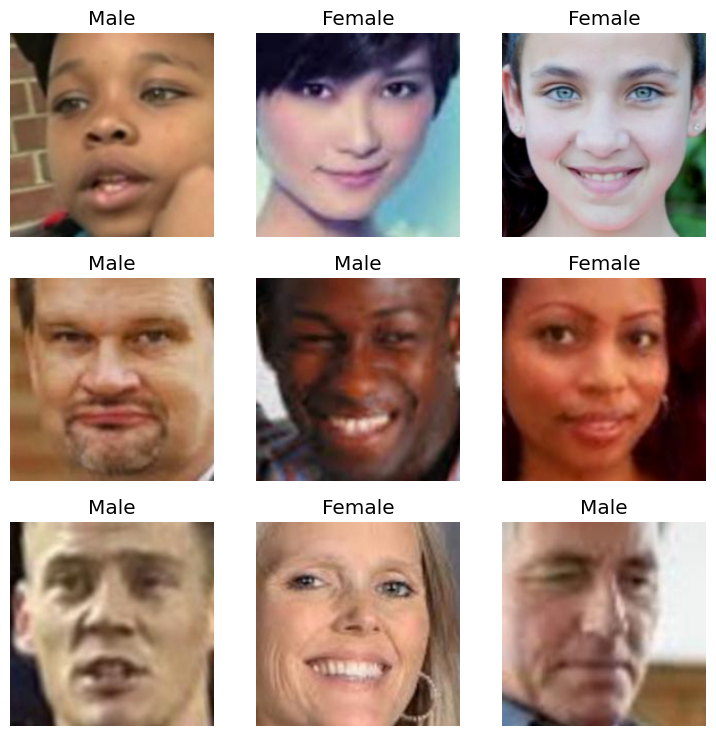

In [ ]:
gender_dataloader.train.show_batch()

In [ ]:
learner = vision_learner(dls=gender_dataloader,
                         arch=resnet50,
                         metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth

100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


SuggestedLRs(valley=0.0006918309954926372)

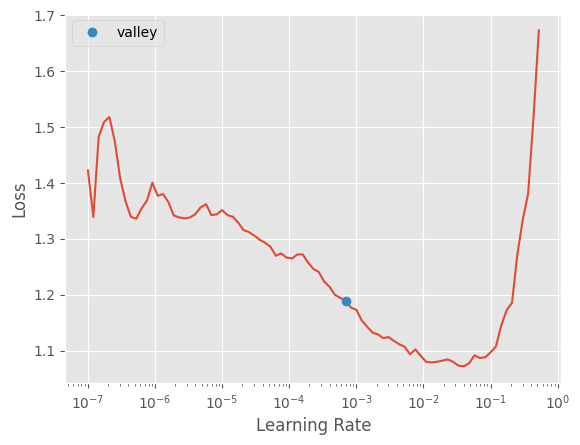

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(epochs=20, base_lr=0.0020892962347716093)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.595978,0.447127,0.789085,0.210915,01:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.362135,0.349419,0.848932,0.151068,01:22
1,0.212226,0.358433,0.857105,0.142895,01:22
2,0.118727,0.415082,0.868178,0.131822,01:22
3,0.093123,0.458851,0.869760,0.130240,01:22
4,0.079162,0.423886,0.873978,0.126022,01:22
5,0.074524,0.421149,0.878460,0.121540,01:23
6,0.057692,0.428833,0.891115,0.108885,01:23
7,0.048684,0.413307,0.896124,0.103876,01:22
8,0.044113,0.441016,0.890061,0.109939,01:22
9,0.033209,0.455835,0.896388,0.103612,01:22


In [ ]:
learner.fit_one_cycle(n_epoch=20, lr_max=slice(1e-4, 1e-1))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.209265,0.441086,0.890061,0.109939,01:23
1,0.265328,0.333395,0.872133,0.127867,01:22
2,0.284362,0.367783,0.838650,0.161350,01:22
3,0.408414,0.730672,0.832586,0.167414,01:22
4,0.470620,0.476656,0.868969,0.131031,01:22
5,0.282213,0.475921,0.889006,0.110994,01:23
6,0.429271,0.685150,0.861851,0.138149,01:22
7,0.323837,0.602446,0.877933,0.122067,01:22
8,0.234751,1.623822,0.782758,0.217242,01:22
9,0.166259,1.002659,0.901925,0.098075,01:22


In [ ]:
learner.unfreeze()
learner.fit_one_cycle(n_epoch=20, lr_max=slice(1e-4, 1e-1))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.364088,0.367282,0.864224,0.135776,02:48
1,0.330000,0.642545,0.814922,0.185078,02:46
2,0.362870,0.334085,0.865542,0.134458,02:46
3,0.399316,0.531482,0.788294,0.211706,02:47
4,0.367967,0.495556,0.865542,0.134458,02:45
5,0.509167,0.577102,0.881624,0.118376,02:46
6,0.252001,21.188276,0.897443,0.102557,02:45
7,0.291967,0.315175,0.890588,0.109412,02:46
8,0.402845,59.224052,0.877669,0.122331,02:46
9,0.207608,2.181988,0.902452,0.097548,02:46


In [ ]:
learner.export("gender_model.pkl")

In [11]:
data = df.copy()

In [12]:
data["age_bin"] = pd.cut(df["image_age"].astype("int"),
                         bins=[0, 14, 24, 54, 64, +np.inf],
                         labels=["children", "early working age", "prime working age", "mature working age", "elderly"])

In [13]:
data.isnull().sum()

image_id        0
image_age       0
image_gender    0
age_bin         0
dtype: int64

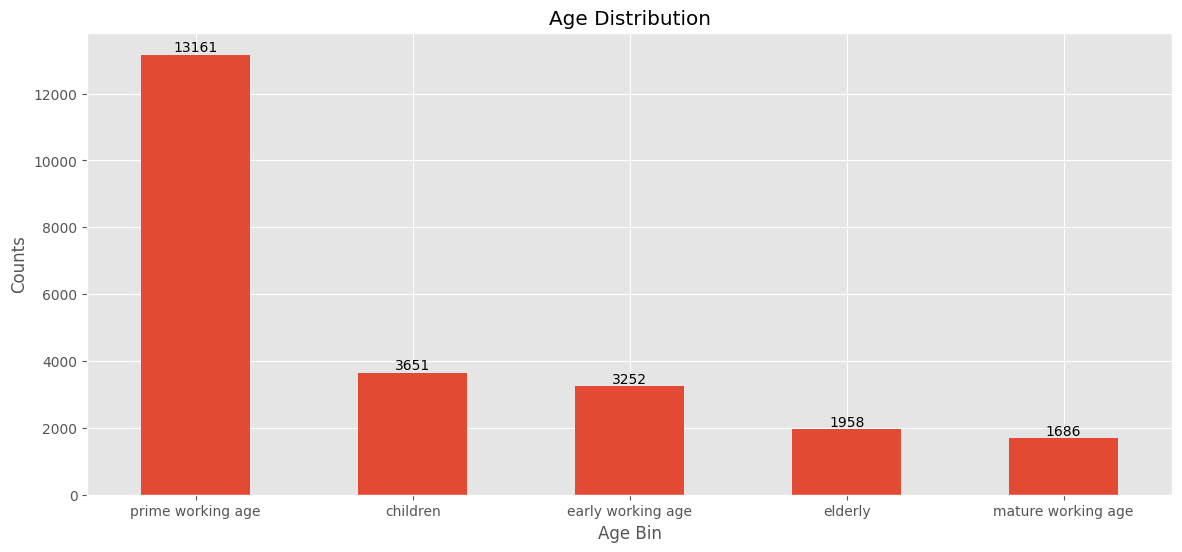

In [14]:
age_dist = data["age_bin"].value_counts().plot(kind="bar",
                                               title="Age Distribution",
                                               figsize=(14, 6),
                                               xlabel="Age Bin",
                                               ylabel="Counts")

for p in age_dist.patches:
    h = p.get_height()
    age_dist.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

age_dist.set_xticklabels(labels=age_dist.get_xticklabels(), rotation=0)

plt.show()

In [15]:
data

,image_id,image_age,image_gender,age_bin
0,75_0_3_20170105180253006.jpg.chip.jpg,75,Male,elderly
1,7_1_4_20170103212641884.jpg.chip.jpg,7,Female,children
2,63_0_3_20170119211951488.jpg.chip.jpg,63,Male,mature working age
3,1_0_0_20170110213508380.jpg.chip.jpg,1,Male,children
4,86_1_0_20170120225525242.jpg.chip.jpg,86,Female,elderly
...,...,...,...,...
23703,56_1_3_20170119192943673.jpg.chip.jpg,56,Female,mature working age
23704,8_1_0_20170109204901514.jpg.chip.jpg,8,Female,children
23705,1_1_3_20161220143222430.jpg.chip.jpg,1,Female,children
23706,63_0_0_20170117195024577.jpg.chip.jpg,63,Male,mature working age


In [16]:
age_train, age_test, age_ytrain, age_ytest = train_test_split(data["image_id"], data["age_bin"], test_size=.001, stratify=data["age_bin"], random_state=42)

age_train_df = pd.concat([age_train, age_ytrain], axis="columns")
age_test_df = pd.concat([age_test, age_ytest], axis="columns")

print(age_train_df.shape, age_test_df.shape)

(23684, 2) (24, 2)


In [17]:
age_train_df["age_bin"].value_counts()

age_bin
prime working age     13148
children               3647
early working age      3249
elderly                1956
mature working age     1684
Name: count, dtype: int64

In [18]:
from imblearn.under_sampling import RandomUnderSampler

downsampler = RandomUnderSampler(random_state=42)

X_downsamp, y_downsamp = downsampler.fit_resample(X=pd.DataFrame(data["image_id"]), y=pd.DataFrame(data["age_bin"]))

age_train_downsamp = pd.concat([X_downsamp, y_downsamp], axis="columns")

age_train_downsamp.shape

(8430, 2)

In [19]:
age_train_downsamp["age_bin"].value_counts()

age_bin
children              1686
early working age     1686
prime working age     1686
mature working age    1686
elderly               1686
Name: count, dtype: int64

In [20]:
age_dataloader = ImageDataLoaders.from_df(df=age_train_df,
                                          folder=path_id,
                                          x_col="image_id",
                                          y_col="age_bin",
                                          item_tfms=Resize(224),
                                          batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()])

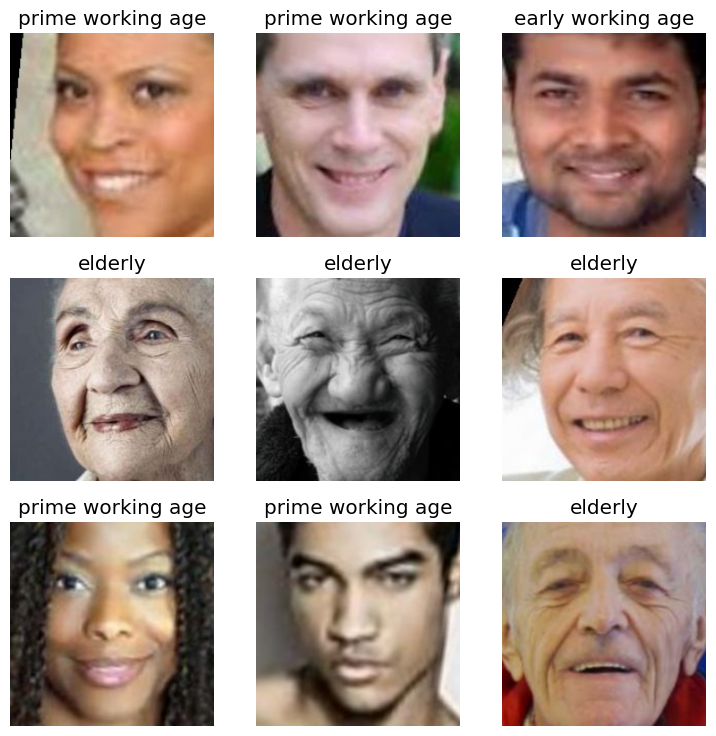

In [ ]:
age_dataloader.train.show_batch()

In [ ]:
age_learner = vision_learner(dls=age_dataloader,
                             arch=resnet50,
                             metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


SuggestedLRs(valley=0.0020892962347716093)

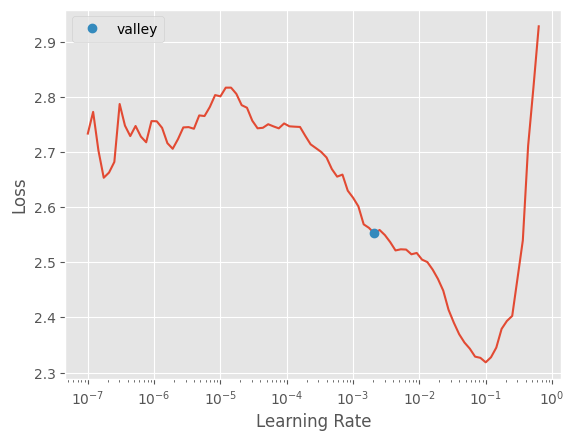

In [ ]:
age_learner.lr_find()

In [ ]:
age_learner.fine_tune(epochs=20, base_lr=0.0008317637839354575)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.398862,1.015240,0.646959,0.353041,02:29


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.935623,0.848917,0.698480,0.301520,03:21
1,0.762650,0.821438,0.709248,0.290752,03:24
2,0.632304,0.794561,0.713682,0.286318,03:24
3,0.521849,0.820561,0.708615,0.291385,03:24
4,0.369235,0.909823,0.709459,0.290541,03:24
5,0.245645,1.021611,0.709037,0.290963,03:25
6,0.162746,1.131122,0.704814,0.295186,03:23
7,0.109413,1.232321,0.717694,0.282306,03:23
8,0.091860,1.287993,0.717061,0.282939,03:23
9,0.071398,1.335999,0.715794,0.284206,03:23


In [ ]:
age_learner.export("age_learner_1.pkl")

In [21]:
age_learner = vision_learner(dls=age_dataloader,
                             arch=resnet50,
                             metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


In [22]:
age_learner.fit_one_cycle(n_epoch=20, lr_max=slice(1e-4, 1e-1))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.101691,0.995936,0.619299,0.380701,02:33
1,0.928808,0.944744,0.656250,0.343750,02:34


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.101691,0.995936,0.619299,0.380701,02:33
1,0.928808,0.944744,0.656250,0.343750,02:34
2,1.163384,1.441511,0.621833,0.378167,02:34
3,1.405915,1.432225,0.674198,0.325802,02:34
4,1.315559,2.327317,0.690034,0.309966,02:34
5,1.132711,1.552610,0.648226,0.351774,02:34
6,1.194999,1.271817,0.716216,0.283784,02:35
7,1.056653,1.844219,0.708826,0.291174,02:34
8,0.935919,1.545743,0.703125,0.296875,02:34
9,0.872145,0.915567,0.685389,0.314611,02:35


In [25]:
age_learner.export("age_learner_2.pkl")

In [24]:
print("Done")

Done


## Eddy